# Self-Driving Car Engineer Nanodegree | Computer Vision
## Project: Vehicle Detection
### by Mohit Arvind Khakharia


The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [32]:
## ALL IMPORT STATEMENTS
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
import random
from skimage.feature import hog
import csv
import matplotlib.image as mpimg

Vehicle Length 8793
Non-Vehicle Length 8968
Shape of Images -  (64, 64, 3)


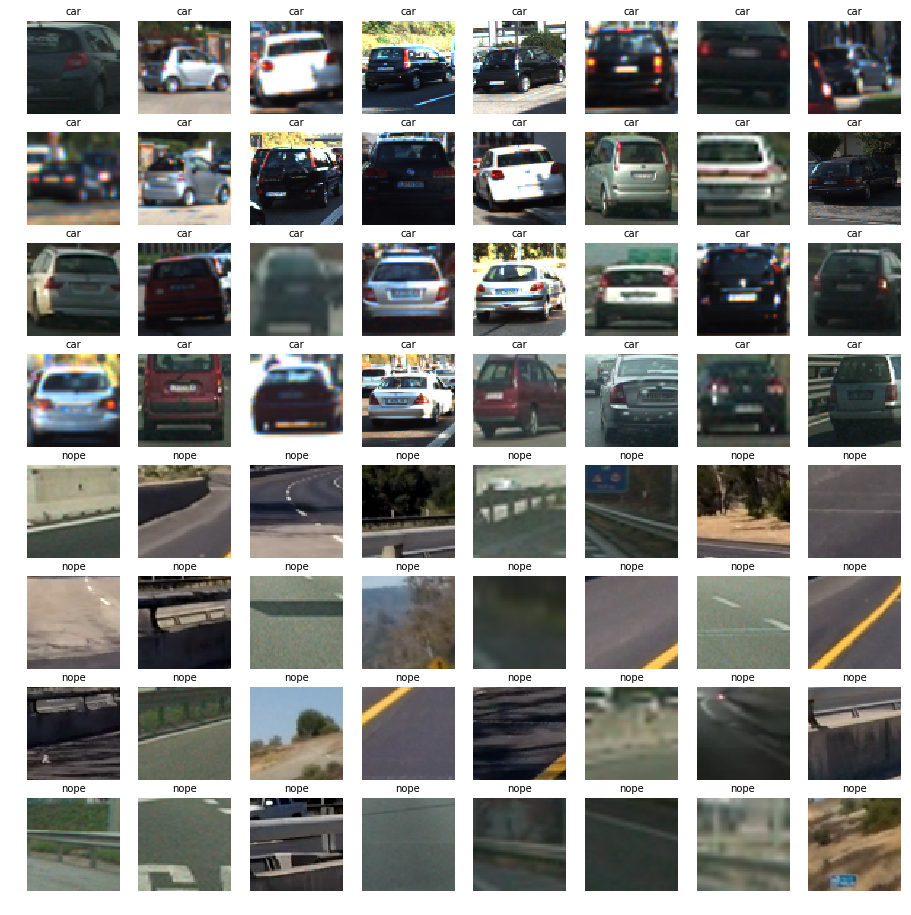

In [33]:
vehicleFolder = 'data/vehicles'
nonVehicleFolder = 'data/non-vehicles'
file_types = ('jpg', 'png')
# read in and count datasets
files_vehicle = []
files_nonVehicle = []
for ext in file_types:
    files_vehicle.extend(glob.glob('{}/**/*.{}'.format(vehicleFolder, ext), recursive=True))
    files_nonVehicle.extend(glob.glob('{}/**/*.{}'.format(nonVehicleFolder, ext), recursive=True))

print("Vehicle Length",len(files_vehicle))
print("Non-Vehicle Length",len(files_nonVehicle))
img = cv2.imread(files_vehicle[0])
print("Shape of Images - ",img.shape)

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(files_vehicle[np.random.randint(0,len(files_vehicle))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(files_nonVehicle[np.random.randint(0,len(files_nonVehicle))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

In [34]:
# Create thresholded binary image
def makeGrayImg(img, mask=None, colorspace='rgb', useChannel=0):
    '''
    Returns a grey image based on the following inputs
    - mask
    - choice of color space
    - choice of channel(s) to use
    '''
    # color space conversion
    if colorspace == 'gray':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGRGRAY)
    elif colorspace == 'hsv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'hls':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'lab':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif colorspace == 'luv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif colorspace == 'yuv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif colorspace == 'ycrcb':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    else: 
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # isolate channel
    if colorspace != 'gray':
        cvt_img = cvt_img[:,:,useChannel]     

    # apply image mask
    if mask is not None:
        imgMask = np.zeros_like(cvt_img)    
        ignore_mask_color = 255
        # filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(imgMask, mask, ignore_mask_color)
        # returning the image only where mask pixels are nonzero
        cvt_img = cv2.bitwise_and(cvt_img, imgMask)
    return cvt_img


def scaleImgValues(img, maxVal=None):
    if maxVal==None:
        maxVal=np.max(img)
    return np.uint8(255*img/maxVal)


def get_color_features(img, color_space='BGR', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


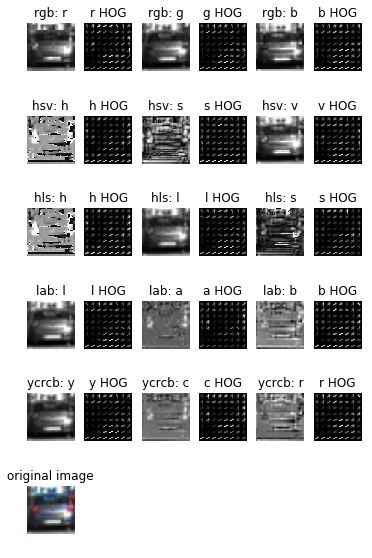

In [35]:

img = cv2.imread(files_vehicle[5])

color_spaces = ('rgb', 'hsv', 'hls', 'lab', 'ycrcb')
fig = plt.figure()
subplot_i = 1


# visualize different color channels
for clrSpace in color_spaces:
    for channel in range(3):
        cvtImg = makeGrayImg(img, mask=None, colorspace=clrSpace, useChannel=channel)
        plt.subplot(6,6,subplot_i)
        plt.imshow(cvtImg, cmap='gray')
        plt.subplots_adjust(top=2.00)
        plt.axis('off')
        plt.title('{}: {}'.format(clrSpace, clrSpace[channel]))
        subplot_i +=1
        feature, hog_img = get_hog_features(cvtImg, 9, 8, 2,vis=True)
        plt.subplot(6,6,subplot_i)
        plt.imshow(hog_img, cmap='gray')
        plt.subplots_adjust(top=2.00)
        plt.axis('off')
        plt.title('{} HOG'.format(clrSpace[channel]))
        subplot_i +=1

cvtImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(6,6,subplot_i)
plt.imshow(cvtImg)
plt.axis('off')
plt.title('original image')

plt.show()

In [36]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

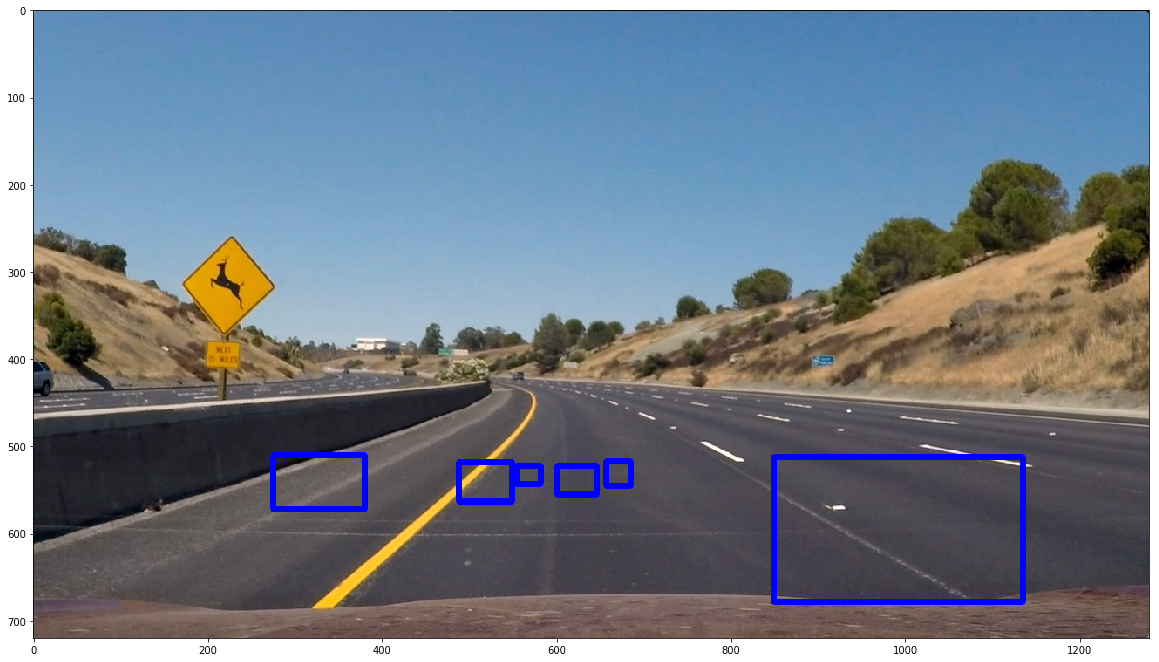

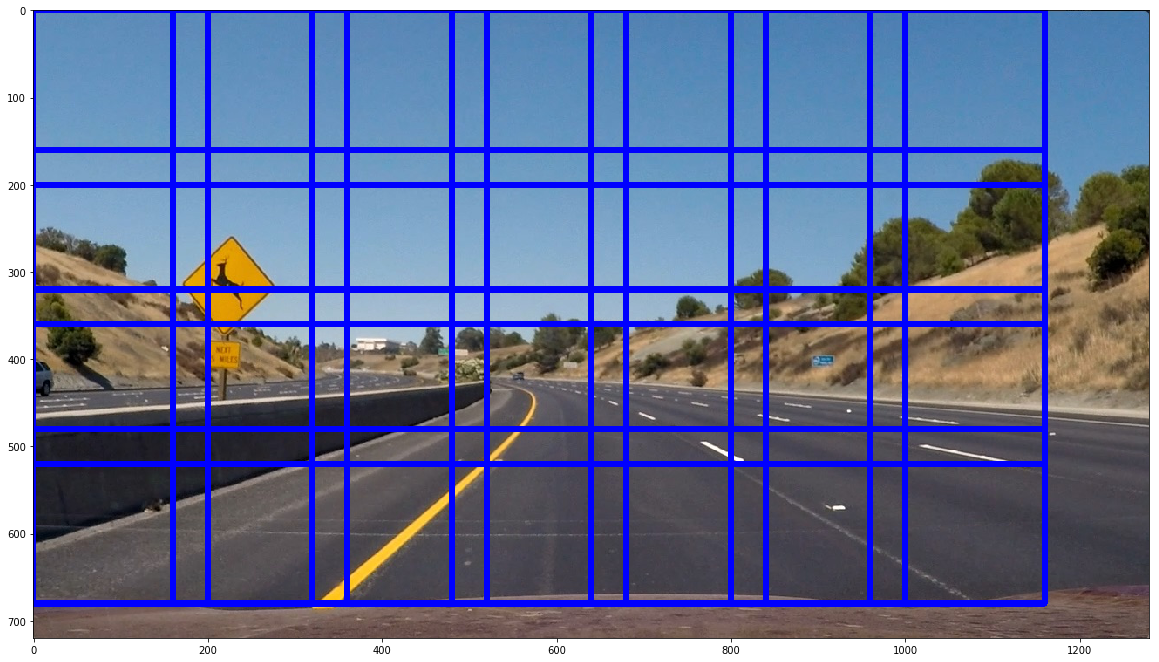

In [39]:
%matplotlib inline
image = mpimg.imread('test_images/test2.jpg')

#Box drawing
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]


result = draw_boxes(image, bboxes)

plt.figure(figsize=(20,20))
plt.imshow(result)

w_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[0, 720], xy_window=(200,200), xy_overlap=(0.2, 0.2))
result = draw_boxes(image, w_list)

plt.figure(figsize=(20,20))
plt.imshow(result)

In [41]:
#Auxiliary functions

from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

(720, 1280, 3)
(256, 1280, 3)


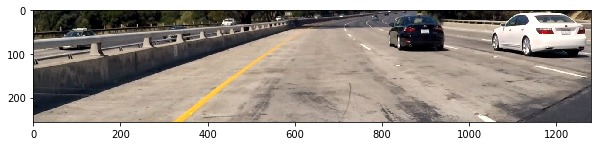

In [43]:
img = mpimg.imread('test_images/test1.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255

ystart = 400
ystop = 656
img_tosearch = img[400:656,:,:]
print(img.shape)
print(img_tosearch.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_tosearch)
#img2 = convert_color(img, conv='RGB2YCrCb')
#print(img2.shape)